In [1]:
import MeCab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from xgboost import XGBClassifier
from collections import Counter

plt.style.use('seaborn-paper')

In [2]:
df = pd.read_csv(r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\data\reviews_kkstream.csv")
df = df[["Review Body", "Reviewer Ratings"]]
df.columns = ["content", "label"]
df["label"] = df["label"].map(lambda x: 1 if int(x)>3 else 0)

In [3]:
df["length"] = df["content"].map(len)
text_len = df["length"].values
max_len = text_len.max()

len_sum = [0] * max_len
for i in text_len:
    len_sum[i-1] += 1
    
len_cum = [len_sum[0]] + [0] * (max_len-1)
for i in range(1, max_len):
    len_cum[i] += len_sum[i] + len_cum[i-1]

print('Cumulative %   # Words  # Comments')
for i in range(max_len):
    len_cum[i] /= len(text_len)
    if len_sum[i] != 0:
        if (len_cum[i] >= 0.8 and len_cum[i-1] < 0.8):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.85 and len_cum[i-1] < 0.85):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.9 and len_cum[i-1] < 0.9):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.92 and len_cum[i-1] < 0.92):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.95 and len_cum[i-1] < 0.95):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))

Cumulative %   # Words  # Comments
 80.57778   	  30 	    24
 85.33333   	  36 	    22
 90.31111   	  46 	    11
 92.17778   	  52 	    6
 95.02222   	  60 	    7


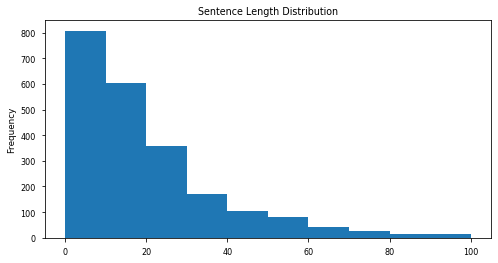

In [4]:
df["length"].plot(kind="hist", 
                  title="Sentence Length Distribution", 
                  range=(0, 100), 
                  figsize=(8, 4))

In [5]:
df = df[df["length"] >= 10]
train, test = train_test_split(df, train_size=0.5, random_state=17)

In [6]:
def create_mecab_list(text=None):
    pos_list = [10, 11, 31, 32, 34]
    pos_list.extend(list(range(36,50)))
    pos_list.extend([59, 60, 62, 67])

    mecab_list = []
    mecab = MeCab.Tagger("-Ochasen")
    mecab.parse("")
    # encoding = text.encode('utf-8')
    node = mecab.parseToNode(text)
    while node:
        if len(node.surface) > 1:
            if node.posid in pos_list:
                morpheme = node.surface
                mecab_list.append(morpheme)
        node = node.next
    return mecab_list

In [7]:
class Word2VecVectorizer:
    def __init__(self):
        print("Loading word vectors...")
        self.w2v = Word2Vec.load(r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\word2vec\ja.bin")
        print("Finished loading in word vectors.")
        
    def fit(self, data):
        pass
    
    def transform(self, data):
        v = self.w2v.wv.get_vector("の")
        self.D = v.shape[0]
        
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = create_mecab_list(sentence)
            vecs = []
            m = 0
            for word in tokens:
                try: 
                    vec = self.w2v.wv.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [8]:
vectorizer = Word2VecVectorizer()
x_train = vectorizer.fit_transform(train.content)
y_train = train.label

x_test = vectorizer.fit_transform(test.content)
y_test = test.label

Loading word vectors...
Finished loading in word vectors.
Number of samples with no words found: 53 / 721
Number of samples with no words found: 52 / 721


In [9]:
print("# of training data: {}\n# of features: {}".format(x_train.shape[0], x_train.shape[1]))
x_train

# of training data: 721
# of features: 300


array([[-1.30616355,  0.35006583,  0.10138483, ..., -0.26193544,
         0.44660771,  0.11711761],
       [-1.24672151, -0.43644291,  1.84824848, ..., -0.19403046,
         0.50636667, -0.50846994],
       [ 0.06402481, -0.2033734 , -0.93853742, ...,  1.11359704,
         0.4840554 ,  0.22776853],
       ...,
       [-0.42218745, -0.27521798,  0.75327069, ...,  1.23346412,
        -0.69093657, -0.4369345 ],
       [-1.07482326,  0.30923462,  0.65014231, ...,  0.90188652,
        -0.29094309, -0.70689541],
       [-1.65390456,  0.21262589,  0.78621626, ...,  1.06683433,
         0.50084603,  0.67041457]])

In [10]:
def performance(model, x_train, y_train, x_test, y_test):
    print("train score: ", round(model.score(x_train, y_train), 4))
    print("test score: ", round(model.score(x_test, y_test), 4))
    print("f-beta score: ", round(f1_score(y_test, model.predict(x_test)), 4))
    print("confusion matrix: \n", confusion_matrix(y_test, model.predict(x_test)))

In [11]:
rfc_model = RandomForestClassifier(
    n_estimators=200, 
    random_state=17)
rfc_model.fit(x_train, y_train)
performance(rfc_model, x_train, y_train, x_test, y_test)

train score:  0.9473
test score:  0.6879
f-beta score:  0.5631
confusion matrix: 
 [[351  88]
 [137 145]]


In [12]:
knn_model = KNeighborsClassifier(
    n_neighbors=10)
knn_model.fit(x_train, y_train)
performance(knn_model, x_train, y_train, x_test, y_test)

train score:  0.7074
test score:  0.6477
f-beta score:  0.5
confusion matrix: 
 [[340  99]
 [155 127]]


In [13]:
xgb_model = XGBClassifier(
    learning_rate=0.01, 
    n_estimators=200, 
    max_depth=4, 
    min_child_weight = 1, 
    gamma=0., 
    subsample=1, 
    colsample_btree=1, 
    scale_pos_weight=1, 
    random_state=17, 
    slient = 0)
xgb_model.fit(x_train, y_train)
performance(xgb_model, x_train, y_train, x_test, y_test)

train score:  0.8974
test score:  0.6685
f-beta score:  0.5631
confusion matrix: 
 [[328 111]
 [128 154]]


In [14]:
etc_model = ExtraTreesClassifier(
    n_estimators=200,
    criterion='gini', 
    random_state=17)
etc_model.fit(x_train, y_train)
performance(etc_model, x_train, y_train, x_test, y_test)

train score:  0.9473
test score:  0.6713
f-beta score:  0.5212
confusion matrix: 
 [[355  84]
 [153 129]]


In [15]:
dtc_model = DecisionTreeClassifier(
    max_depth=5, 
    criterion='gini', 
    random_state=17)
dtc_model.fit(x_train, y_train)
performance(dtc_model, x_train, y_train, x_test, y_test)

train score:  0.767
test score:  0.638
f-beta score:  0.4932
confusion matrix: 
 [[333 106]
 [155 127]]


In [16]:
eclf = VotingClassifier(
    estimators=[('rfc', rfc_model), ('xgb', xgb_model), ('etc', etc_model), ('dtc', dtc_model)],
    voting='soft')
eclf.fit(x_train, y_train)
performance(eclf, x_train, y_train, x_test, y_test)

train score:  0.9473
test score:  0.656
f-beta score:  0.5321
confusion matrix: 
 [[332 107]
 [141 141]]
